# Algoritmo K-means en Pyspark


###**Integrantes**
1.   CASILLA PERCCA, Vladimir Dante              174908
2.   HUAMAN HERMOZA, Antony Isaac                115575
3.   INCA CRUZ, Carlos Eduardo                   174912
4.   PEREIRA CHINCHERO, Richard Mikhael			 171916
5.   QUISPE CHAMBILLA, Carlos Enrique		  	 174447
6.   QUISPE PALOMINO, Luiyi Antoni			  	 174914

#1.- Diagrama de Flujos

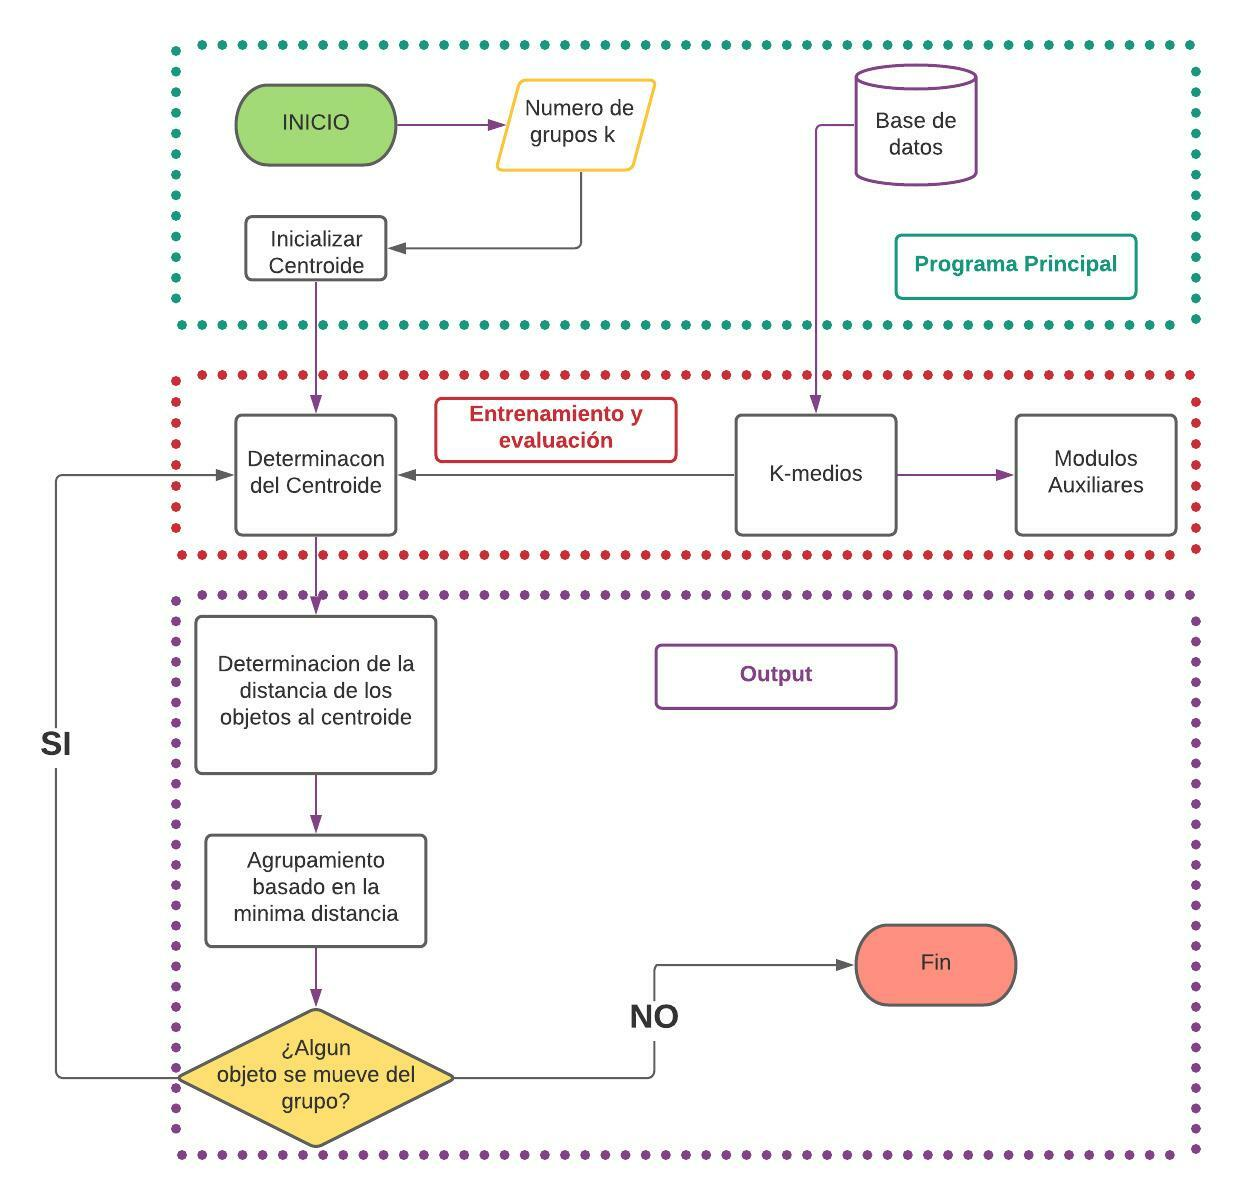

#2.- Complejidad del Algoritmo

### > Algoritmo k means:
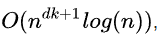

siendo 'k' el numero de clusters, 'd' el numero de atributos por datos, y 'n' el numero de datos en total

#3.- Codificacion del Algoritmo

# Instalar pyspark e importar librerias

#Importar Librerias

In [ ]:
import numpy as np 
import pickle 
import sys 
import time
from numpy.linalg import norm 
from matplotlib import pyplot as plt
import pandas as pd
from google.colab import output
from google.colab import data_table
from PIL import Image

Instalar pyspark

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark en Google Colab").getOrCreate()
sc=spark.sparkContext
output.clear()
print(spark.sparkContext.appName)

PySpark en Google Colab


# Implementar algoritmo k means


**Inicializar kmeans**



In [ ]:
def eleccion(p):
    '''
    Genera una muestra aleatoria de [0, len(p)),
    donde p[i] es la probabilidad asociada con i.
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)
def kmeans_inicializacion(rdd, K):
    '''
    Seleccionar conjuntos `RUNS` de puntos iniciales para `K`-means
    '''
    RUNS=K
    # la variable 'centers' es lo que buscamos retornar al final de la funcion
    n_data = rdd.count()
    shape = rdd.take(1)[0][1].shape[0]
    centers = np.zeros((RUNS, K, shape))
    def update_distancia(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2
        return np.min([dist, new_dist], axis=0)

    # El segundo elemento 'dist' en la tupla a continuación 
    # es la distancia más cercana desde cada punto de datos a los 
    # puntos seleccionados en el conjunto inicial, donde 'dist[i]' 
    # es la distancia más cercana a los puntos en el i-ésimo conjunto inicial
    data = (rdd.map(lambda p: (p, [np.inf] * RUNS)).cache())
    
    # Recopilar los vectores de características de todos los puntos 
    # de datos de antemano, podría ser útil en el siguiente 
    # bucle for
    local_data = (rdd.map(lambda x: x[1]).collect())

    # Son seleccionados aleatoriamente el primer punto para cada ejecución de 
    # k-means, es decir, seleccionamos aleatoriamente los puntos 'RUNS' 
    # y agrégamos en la variable 'centers'
    ejemplo = [local_data[k] for k in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = ejemplo
    for idx in range(K - 1):
        ############################################## ######
        # En cada iteración, debemos seleccionar un punto para cada conjunto 
        # de puntos iniciales (así que seleccione los puntos `RUNS` en total). 
        # Para cada punto de datos x, sea D_i(x) la distancia entre x y el 
        # centro más cercano que ya se ha agregado al i-ésimo conjunto. Elejimos
        # un nuevo punto de datos para el i-ésimo conjunto usando una 
        # probabilidad ponderada donde el punto x se elige con una probabilidad 
        # proporcional a D_i(x)^2 . Repitamos cada punto de datos 25 veces (para cada 
        # EJECUCIÓN) para obtener 12140x25
        ############################################## ######
        # Actualizar distancia
        data = (data.map(lambda x:((x[0][0],x[0][1]),update_distancia(x[0][1],x[1],idx))).cache())
        # Calcular la suma de D_i(x)^2
        d1 = data.map(lambda x: (1,x[1]))
        d2 = d1.reduceByKey(lambda x,y: np.sum([x,y], axis=0))
        total = d2.collect()[0][1]
        # Normalizar cada distancia para obtener las probabilidades y
        # reformar a 12140x25
        prob = (data.map(lambda x:np.divide(x[1],total)).collect())
        prob = np.reshape(prob,(len(local_data), RUNS))
        # K'esimo centroide para cada iteracion
        data_id = [eleccion(prob[:,i]) for i in range(RUNS)]
        ejemplo = [local_data[i] for i in data_id]
        centers[:, idx+1] = ejemplo
    return centers
def obtener_mascercano(p, centers):
    '''
    Devuelve los índices a los centroides más cercanos de 'p'.
    'centers' contiene conjuntos de centroides, donde 'centers[i]' es
    el i-ésimo conjunto de centroides.
    '''
    mejor = [0] * len(centers)
    cercano = [np.inf] * len(centers)
    for idx in range(len(centers)):
        for j in range(len(centers[0])):
            temp_distancia = norm(p - centers[idx][j])
            if temp_distancia < cercano[idx]:
                cercano[idx] = temp_distancia
                mejor[idx] = j
    return mejor

**Modulo Principal**

In [ ]:
def kmeans(rdd, K, converge_dist=0.1):
    '''
    Ejecute el algoritmo K-means en 'rdd', donde 'RUNS'
    es el número de conjuntos iniciales a usar.
    '''
    k_puntos = kmeans_inicializacion(rdd, K)
    print("Primeros centroides inicializados............")
    temp_distancia = 1.0

    iters = 0
    st = time.time()
    # El algoritmo termina si 'temp_distancia' que representa el cambio de 
    # posiciones de los centroides varia menos que 'converge_dist' 
    # osea que todos los centroides casi ni se han movido
    while temp_distancia > converge_dist:

        # Actualice todos los conjuntos de centroides `RUNS` usando el algoritmo estándar k-means
        # Esquema:
        # - Para cada punto x, seleccione su centroide más cercano en el i-ésimo conjunto de centroides
        # - Promedio de todos los puntos que están asignados al mismo centroide
        # - Actualizar el centroide con el promedio de todos los puntos que se le asignan

        # Para cada punto x, seleccione su centroide más cercano en el i-ésimo conjunto de centroides
        # Formato: ((RUN, centroide_cercano), puntos_coordenadas)
        cen_rdd1 = rdd.flatMap(lambda p: [((indx,j),p[1]) for (indx,j) in enumerate(obtener_mascercano(p[1], k_puntos))])
        # Introducir 1 para contar
        # Formato: ((RUN, centroide_cercano), point, 1)
        cen_rdd2 = cen_rdd1.map(lambda x: ((x[0][0], x[0][1]), np.array([x[1], 1])))
        # Sumar todas la distancias y sumar los 1's (contar)   
        # Formato: ((RUN, centroide_cercano), sum_puntos, count)
        cen_rdd3 = cen_rdd2.reduceByKey(lambda x,y: np.sum([x,y], axis=0))
        # Calcular la distancia media para cada RUN 
        # Formato: ((RUN, centroide_cercano), distancia_media)
        cen_rdd4 = cen_rdd3.map(lambda x: ((x[0][0], x[0][1]), x[1][0]/x[1][1]))
        # Obtener diccionario de 'nuevos_puntos'
        nuevos_puntos = cen_rdd4.collectAsMap()
        
        # Puede modificar esta declaración siempre que 'temp_dist' sea igual a
        temp_distancia = np.max([np.sum([norm(k_puntos[idx][j] - nuevos_puntos[(idx, j)]) for idx,j in nuevos_puntos.keys()])])

        iters = iters + 1
        if iters % 1 == 0:
            print("Iteracion %d max shift: %.2f (tiempo: %.2f segundos)" %(iters, temp_distancia, time.time() - st))
            st = time.time()

        # Actualizar los centroides antiguos
        # Usted modifica este ciclo for para satisfacer su necesidad
        for ((idx, j), p) in nuevos_puntos.items():
            k_puntos[idx][j] = p

    return k_puntos

# 4.Utilizar algoritmo en un dataset pequeño iris.csv

In [ ]:
#Verficar datos numericos
def Comprobar(palabra):
    '''
    Comprobar si una cadena es numero o texto
    '''
    try:
	    entero = float(palabra)
	    return True
    except ValueError:
	    return False

#Leer y dar formato al dataset
rawData = sc.textFile("/content/iris_kmeans.csv")
rdd = sc.parallelize((rawData.collect()))
rdd=rdd.map(lambda x:  [i for i in x.split(",") ])
rdd=rdd.filter(lambda x:  (Comprobar(x[0]) and  Comprobar(x[1])) )
rdd=rdd.map(lambda x:  np.array([float(x[0]),float(x[1])]))
rdd = sc.parallelize(enumerate(rdd.collect()))

#Mostrar rdd preprocesado
dfrdd=pd.DataFrame(rdd.collect(),columns=['Id','Data'],index=None)
data_table.DataTable(dfrdd, include_index=False, num_rows_per_page=20)


,Id,Data
0,0,"[5.0, 0.2]"
1,1,"[5.4, 0.4]"
2,2,"[4.6, 0.3]"
3,3,"[4.9, 0.1]"
4,4,"[5.4, 0.2]"
5,5,"[5.1, 0.5]"
6,6,"[7.0, 1.4]"
7,7,"[6.4, 1.5]"
8,8,"[5.7, 1.3]"
9,9,"[6.3, 1.6]"


In [ ]:
# Número de centroides
K = 2

# El algoritmo de K-medias finaliza cuando el cambio en la 
# ubicación de los centroides es menor que 0.1
converge_dist = 0.1

# calcular tiempos
st = time.time()

# utilizar k means
centroides = kmeans(rdd, K)
# obtener el cluster mas cercano de para cada uno de los  puntos p
grupo = rdd.mapValues(lambda p: obtener_mascercano(p, centroides))

# Mostrar tiempo tomado
print ("Tiempo tomado para la convergencia:", time.time() - st," segundos")

#Mostrar rdd preprocesado
dfrdd=pd.DataFrame(grupo.collect(),columns=['Id','Cluster'],index=None)
data_table.DataTable(dfrdd, include_index=False, num_rows_per_page=20)

Primeros centroides inicializados............
Iteracion 1 max shift: 8.40 (tiempo: 0.14 segundos)
Iteracion 2 max shift: 0.00 (tiempo: 0.14 segundos)
Tiempo tomado para la convergencia: 0.6642038822174072  segundos


,Id,Cluster
0,0,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
1,1,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
2,2,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
3,3,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
4,4,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
5,5,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0]"
6,6,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1]"
7,7,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1]"
8,8,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1]"
9,9,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1]"


Mostrar grafica

In [ ]:
#Buscar el vector de caracteristicas por el ID
cl=rdd.join(grupo)
# Id, el vector de caracteristicas, y el cluster
cl=cl.map(lambda x:(x[0],x[1][0],x[1][1]))
#Mostrar rdd preprocesado
dfrdd=pd.DataFrame(cl.collect(),columns=['Id','Puntos','Cluster'],index=None)
data_table.DataTable(dfrdd, include_index=False, num_rows_per_page=20)
#Pasar el dataframe a arreglos
X = [x[0] for x in dfrdd['Puntos'].tolist()]
Y = [x[1] for x in dfrdd['Puntos'].tolist()]
prediccion = [x[-1] for x in dfrdd['Cluster'].tolist()]


In [ ]:
print(X)
print(Y)
print(prediccion)

[5.0, 5.4, 5.7, 6.7, 6.3, 5.4, 5.1, 6.3, 6.3, 6.5, 4.6, 7.0, 4.9, 5.8, 6.5, 4.9, 6.4, 6.7, 7.1, 6.2]
[0.2, 0.2, 1.3, 1.7, 1.8, 0.4, 0.5, 1.6, 2.5, 2.2, 0.3, 1.4, 1.0, 1.9, 2.0, 0.1, 1.5, 1.4, 2.1, 2.3]
[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]


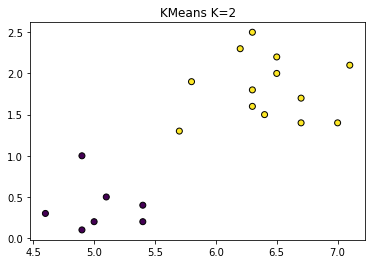

In [ ]:
# graficar
plt.scatter(
        x = X,
        y = Y, 
        c = prediccion,
        #cmap='viridis',
        marker    = 'o',
        edgecolor = 'black'
    )
plt.title('KMeans K=2');

# 5.Una demostración del agrupamiento de K-Means en los datos de dígitos escritos a mano

In [ ]:
def kmeans_fit(rdd,K):
    "Devuelve un np.array con los clusters del rdd"
    # calcular tiempos
    st = time.time()
    centroides = kmeans(rdd, K)
    grupo = rdd.mapValues(lambda p: obtener_mascercano(p, centroides))
    
    #Obtener solo el cluster de la ultima iteracion
    grupo1=grupo.map(lambda p:(p[0],p[1][-1]))

    #Mostrar el tiempo usado en la convergencia
    print ("Tiempo tomado para la convergencia:", time.time() - st," segundos")
    #Mostrar solo el cluster
    pd0=grupo1.map(lambda x:x[1])
    lista=[i for i in pd0.collect()]
    return np.array(lista)

Vamos a clasificar dígitos de la base de datos contenida en la librería sklearn de python utilizando el algoritmo k-means.

In [ ]:
from sklearn.datasets import load_digits

cargar las imágenes de los dígitos y cargamos los datos, que están incluídos en la librería sklearn

In [ ]:
digits = load_digits()
data = digits.data

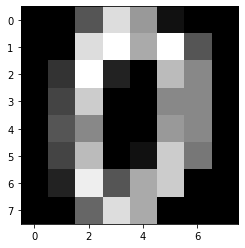

In [ ]:
imagen = data[0]
imagen = imagen.reshape(8, 8)
plt.imshow(imagen, cmap=plt.cm.gray)

En la matriz data, cada fila se corresponde con la imagen de un dígito. Los píxeles de la imagen rectangular de  8×8  píxeles se han recolocado en una fila de  64  elementos. Por lo tanto, cada fila es un objeto o dato. Las características o propiedades de cada objeto son las intensidades de gris de cada pixel. Es decir, tenemos, para cada imagen,  64  propiedades.

Para visualizar mejor los dígitos, vamos a invertir los colores

In [ ]:
data = 255-data

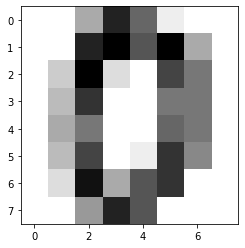

In [ ]:
imagen = data[0]
imagen = imagen.reshape(8, 8)
plt.imshow(imagen, cmap=plt.cm.gray)

In [ ]:
print(data[0])

[255. 255. 250. 242. 246. 254. 255. 255. 255. 255. 242. 240. 245. 240.
 250. 255. 255. 252. 240. 253. 255. 244. 247. 255. 255. 251. 243. 255.
 255. 247. 247. 255. 255. 250. 247. 255. 255. 246. 247. 255. 255. 251.
 244. 255. 254. 243. 248. 255. 255. 253. 241. 250. 245. 243. 255. 255.
 255. 255. 249. 242. 245. 255. 255. 255.]


Fijamos la semilla para sortear los centroides iniciales, para que los resultados obtenidos aquí sean repetibles

In [ ]:
np.random.seed(1)

Introducimos la data en un rdd

In [ ]:
rdd=sc.parallelize(enumerate([i for i in data]))

Como tenemos 10 dígitos diferentes (del 0 al 9) escogemos agrupar las imágenes en  10  clusters

In [ ]:
Z=kmeans_fit(rdd,10)

Primeros centroides inicializados............
Iteracion 1 max shift: 2134.70 (tiempo: 1.73 segundos)
Iteracion 2 max shift: 526.16 (tiempo: 1.69 segundos)
Iteracion 3 max shift: 319.49 (tiempo: 1.89 segundos)
Iteracion 4 max shift: 235.01 (tiempo: 1.69 segundos)
Iteracion 5 max shift: 181.02 (tiempo: 1.76 segundos)
Iteracion 6 max shift: 146.43 (tiempo: 1.86 segundos)
Iteracion 7 max shift: 95.15 (tiempo: 1.72 segundos)
Iteracion 8 max shift: 70.93 (tiempo: 1.66 segundos)
Iteracion 9 max shift: 56.54 (tiempo: 1.66 segundos)
Iteracion 10 max shift: 46.74 (tiempo: 1.68 segundos)
Iteracion 11 max shift: 32.13 (tiempo: 1.71 segundos)
Iteracion 12 max shift: 20.45 (tiempo: 1.71 segundos)
Iteracion 13 max shift: 15.42 (tiempo: 1.66 segundos)
Iteracion 14 max shift: 9.85 (tiempo: 1.65 segundos)
Iteracion 15 max shift: 8.01 (tiempo: 1.68 segundos)
Iteracion 16 max shift: 7.89 (tiempo: 1.79 segundos)
Iteracion 17 max shift: 8.37 (tiempo: 1.68 segundos)
Iteracion 18 max shift: 7.22 (tiempo: 1.66

Mostramos los 10 clusters con sus imagenes respectivas

CLUSTER 0
170 ELEMENTOS


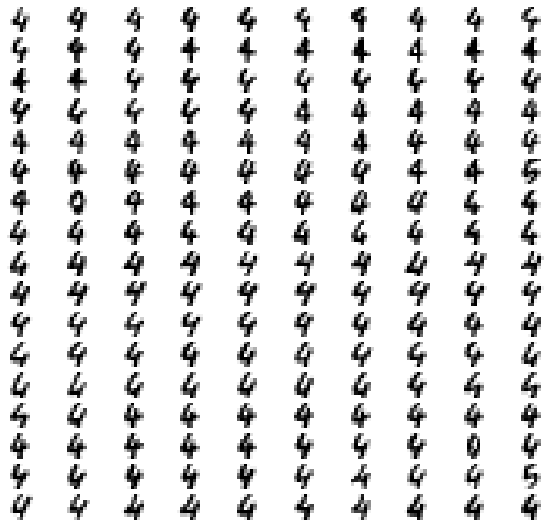

CLUSTER 1
176 ELEMENTOS


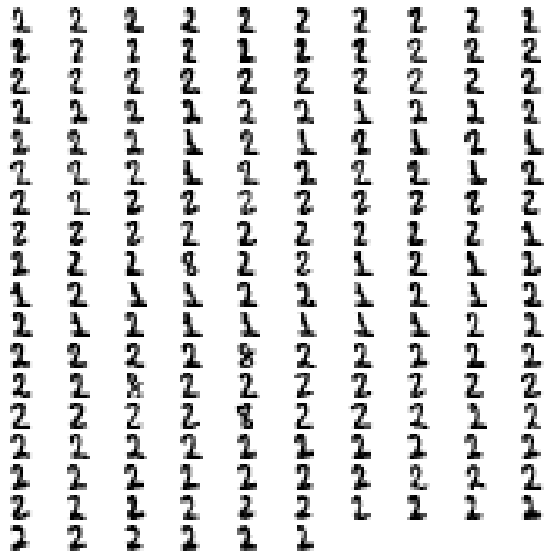

CLUSTER 2
178 ELEMENTOS


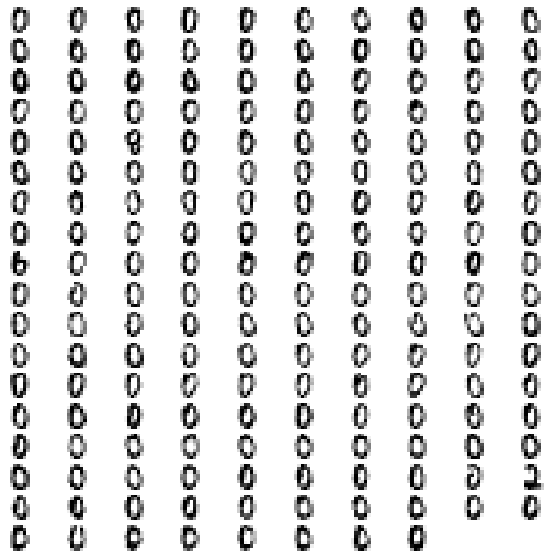

CLUSTER 3
93 ELEMENTOS


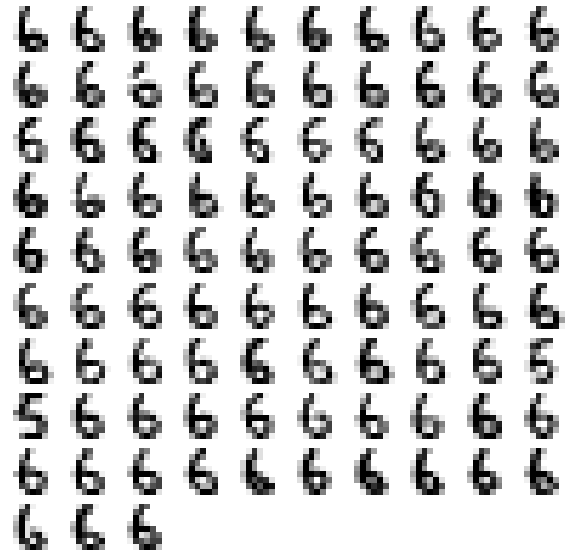

CLUSTER 4
93 ELEMENTOS


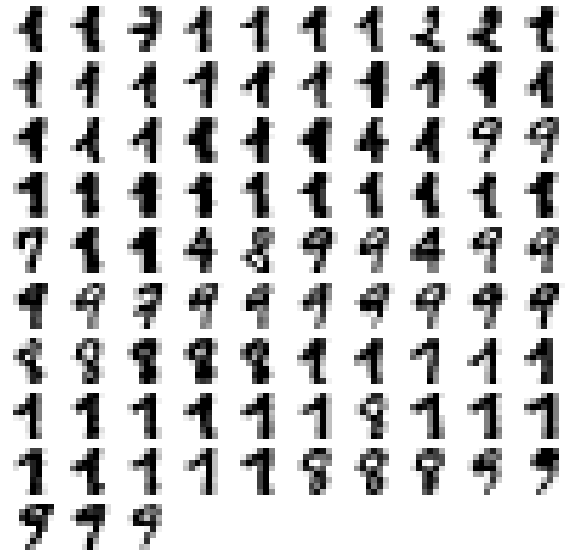

CLUSTER 5
151 ELEMENTOS


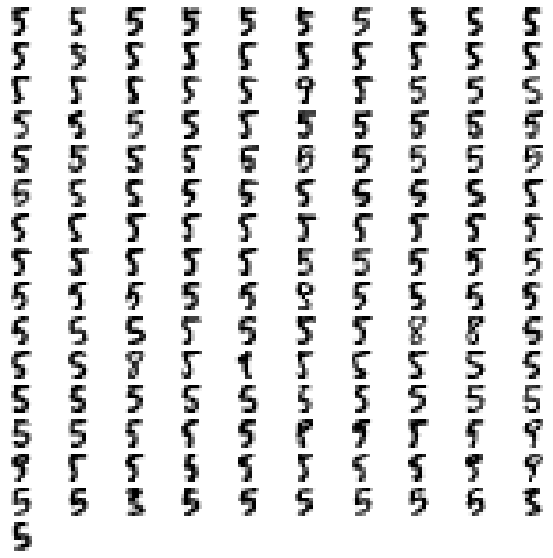

CLUSTER 6
224 ELEMENTOS


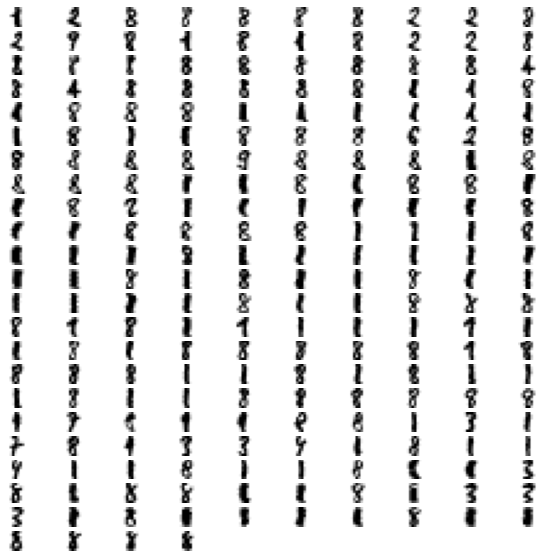

CLUSTER 7
408 ELEMENTOS


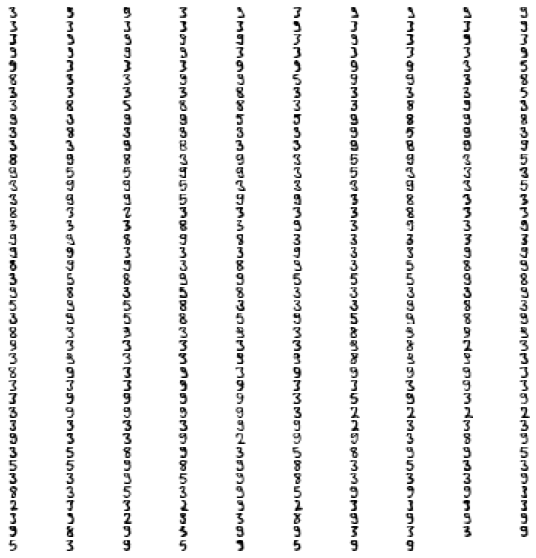

CLUSTER 8
101 ELEMENTOS


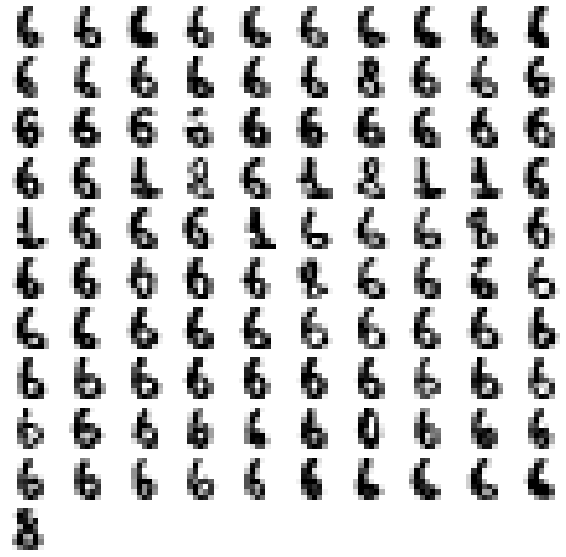

CLUSTER 9
203 ELEMENTOS


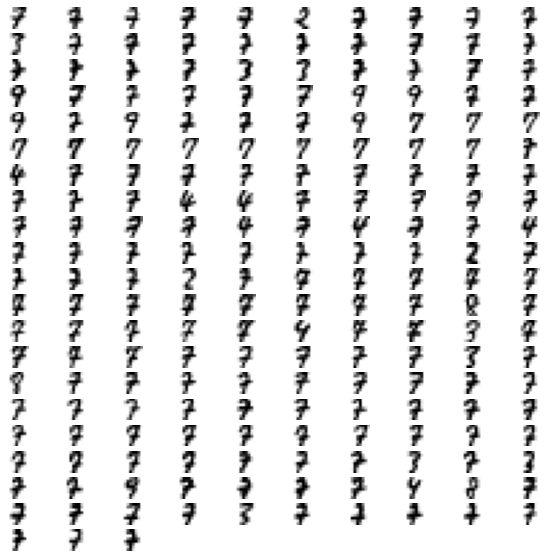

In [ ]:
n=10
for i in range(0,n):

    fila = np.where(Z==i)[0] # filas en Z donde están las imagenes de cada cluster
    num = fila.shape[0]      # numero imagenes de cada cluster
    r = np.floor(num/10.)    # numero de filas menos 1 en figura de salida 

    print("CLUSTER "+str(i))
    print(str(num)+" ELEMENTOS")

    plt.figure(figsize=(10,10))
    for k in range(0, num):
        plt.subplot(r+1, 10, k+1)
        imagen = data[fila[k], ]
        imagen = imagen.reshape(8, 8)
        plt.imshow(imagen, cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()